# NIRCam photutils detections matched to input catalog

How well do we detect the simulated galaxies? Beginning to quantify completeness and contamination of Photutils catalog.

http://github.com/dancoe/ceers

Analyzing simulated NIRCam images from  
CEERS SDR3: Simulated Data Release 3   
https://ceers.github.io/sdr3.html  
NIRCam images in 6 filters: F115W F150W F200W F277W F356W F444W  
0.03" / pixel image reductions (native SW ~0.03", LW ~0.06")  

In [1]:
import numpy as np
import os
from glob import glob
from copy import deepcopy
from os.path import expanduser
home = expanduser("~")
from packaging import version

import astropy  # version 4.2 is required to write magnitudes to ecsv file
from astropy.io import fits
import astropy.wcs as wcs
from astropy.table import QTable, Table
import astropy.units as u
from astropy.visualization import make_lupton_rgb, SqrtStretch, LogStretch, hist, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.coordinates import SkyCoord

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
#%matplotlib inline   # non-interactive (easier for notebook scrolling)
%matplotlib notebook
#plt.style.use(os.path.join(home, 'p', 'matplotlibrc.txt')) # https://matplotlib.org/tutorials/introductory/customizing.html
plt.style.use('https://www.stsci.edu/~dcoe/matplotlibrc.txt') # https://matplotlib.org/tutorials/introductory/customizing.html
mpl_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
# Show versions of Python and imported libraries
try:
    import watermark
    %load_ext watermark
    # %watermark -n -v -m -g -iv
    %watermark -iv -v
except ImportError:
    pass

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.4.0

packaging : 21.3
watermark : 2.3.1
astropy   : 5.1
matplotlib: 3.5.2
numpy     : 1.22.4



# Show Photutils output catalog detections

In [5]:
# Catalog: ecsv format preserves units for loading in Python notebooks
field = 'ceers5'
output_catalog_file = os.path.join('', field + '_total_detections.cat')

#output_catalog_file = field + '_photometry.cat'
#output_catalog_file = os.path.join('../phot3', output_catalog_file)
#output_catalog_file = field + '_phot-eazy.cat'
#output_catalog_file = os.path.join('../eazy3', output_catalog_file)
output_catalog = astropy.io.ascii.read(output_catalog_file)

In [6]:
output_catalog.columns

<TableColumns names=('id','x','y','ra','dec','area','a','b','fwhm','ellipticity','orientation','gini','kron_radius','local_background','segment_flux','segment_fluxerr','kron_flux','kron_fluxerr','segment_mag','segment_magerr','kron_mag','kron_magerr')>

In [7]:
#image_file = '../images/ceers5_f200w_sci.fits.gz'
image_file = '../images/ceers5_total_sci.fits.gz'
image_hdu_list = fits.open(image_file)
idata = 1  # fits extension where data lives
image_data = image_hdu_list[idata].data
imwcs = wcs.WCS(image_hdu_list[idata].header, image_hdu_list)

<IPython.core.display.Javascript object>


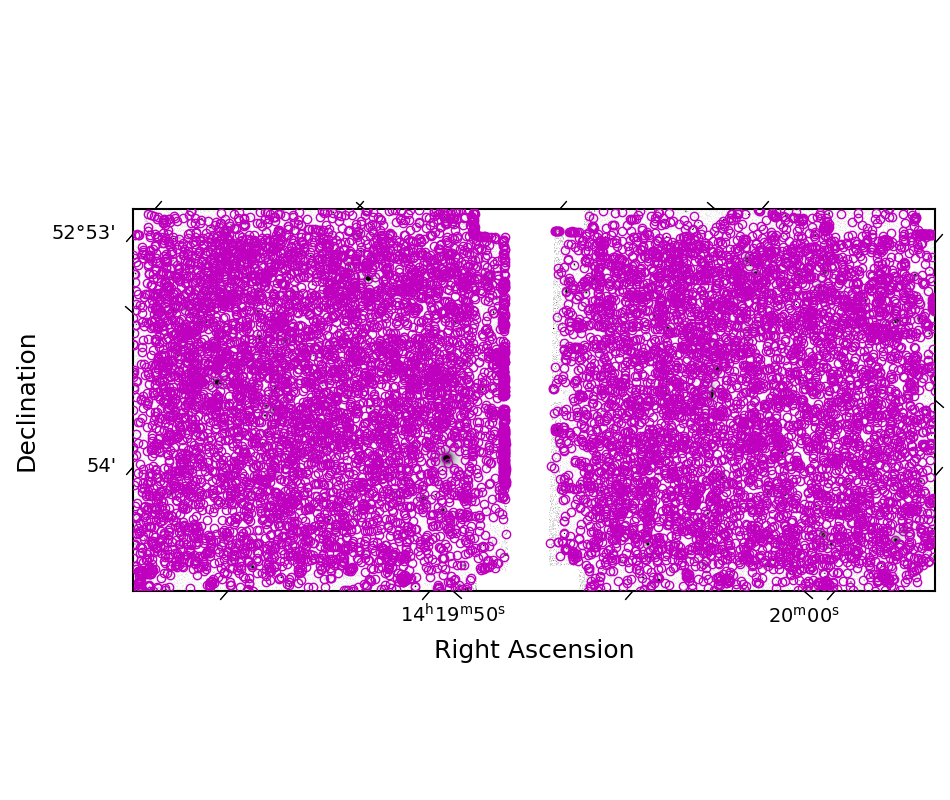

In [8]:
# Show detections on image

fig = plt.figure(figsize=(9.5, 8))
ax = fig.add_subplot(1, 1, 1, projection=imwcs) # , sharex=True, sharey=True)
norm = ImageNormalize(stretch=SqrtStretch(), vmin=0, vmax=0.5)
plt.imshow(image_data, origin='lower', norm=norm, interpolation='none', cmap='Greys')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.plot(output_catalog['ra'], output_catalog['dec'], 'mo', mfc='None', transform=ax.get_transform('world'))

In [ ]:
# Show detections on image

fig = plt.figure(figsize=(9.5, 8))
ax = fig.add_subplot(1, 1, 1, projection=imwcs) # , sharex=True, sharey=True)
norm = ImageNormalize(stretch=SqrtStretch(), vmin=0, vmax=0.5)
plt.imshow(image_data, origin='lower', norm=norm, interpolation='none', cmap='Greys')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.plot(output_catalog['ra'], output_catalog['dec'], 'mo', mfc='None', transform=ax.get_transform('world'))

In [9]:
import photutils
# Segmentation map
segm_file = 'ceers5_total_detections_segm.fits.gz'
segm_data = fits.open(segm_file)[0].data
segm = photutils.segmentation.SegmentationImage(segm_data)

<IPython.core.display.Javascript object>


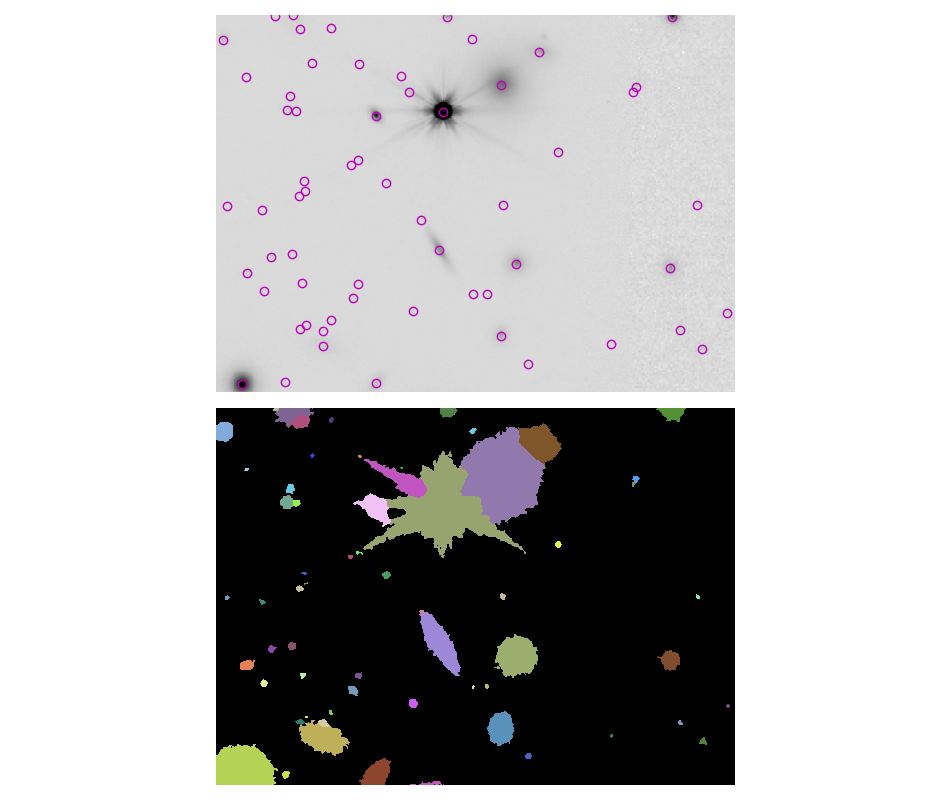

In [11]:
#fig, ax = plt.subplots(1, 2, figsize=(9.5,5), sharex=True, sharey=True)
fig, ax = plt.subplots(2, 1, figsize=(9.5, 8), sharex=True, sharey=True)

#norm = simple_norm(image_data, 'sqrt', min_percent=0.1, max_percent=99.9)
norm = simple_norm(image_data, 'sqrt', min_percent=0.1, max_percent=99.9)
ax[0].imshow(image_data, origin='lower', interpolation='none', norm=norm, cmap='Greys' )
ax[0].plot(output_catalog['x'], output_catalog['y'], 'mo', mfc='None')

cmap = segm.make_cmap(seed=123)
ax[1].imshow(segm, origin='lower', interpolation='none', cmap=cmap)

for ix in range(2):
    ax[ix].axis('off')

# Show input catalog objects

In [14]:
input_catalog_file = '../inputs/CEERS_SDR3_SAM_input.fits'
complete_input_catalog = Table.read(input_catalog_file)

In [15]:
def between(lo, x, hi, tol=0):
    return (lo-tol < x) & (x < hi+tol)

In [18]:
# Trim to objects within RA & Dec range of output_catalog
tolerance = 0.001  # allow for edge objects: 0.001 deg ~3.6" sort of (depends on dec)
ra_good = between( min(output_catalog['ra']),  complete_input_catalog['ra'],  max(output_catalog['ra']),  tolerance)
dec_good = between(min(output_catalog['dec']), complete_input_catalog['dec'], max(output_catalog['dec']), tolerance)
#radec_good = ra_good * dec_good
#input_catalog = complete_input_catalog[all_good]

In [29]:
# Trim to objects within x & y range of output_catalog
complete_input_coordinates = SkyCoord(ra=complete_input_catalog['ra']*u.deg, dec=complete_input_catalog['dec']*u.deg)
complete_input_catalog['x'], complete_input_catalog['y'] = imwcs.world_to_pixel(complete_input_coordinates)
x_good = between(min(output_catalog['x']), complete_input_catalog['x'], max(output_catalog['x']), 1)
y_good = between(min(output_catalog['y']), complete_input_catalog['y'], max(output_catalog['y']), 1)
all_good = ra_good * dec_good * x_good * y_good
input_catalog = complete_input_catalog[all_good]

In [30]:
len(input_catalog)

27255

<IPython.core.display.Javascript object>


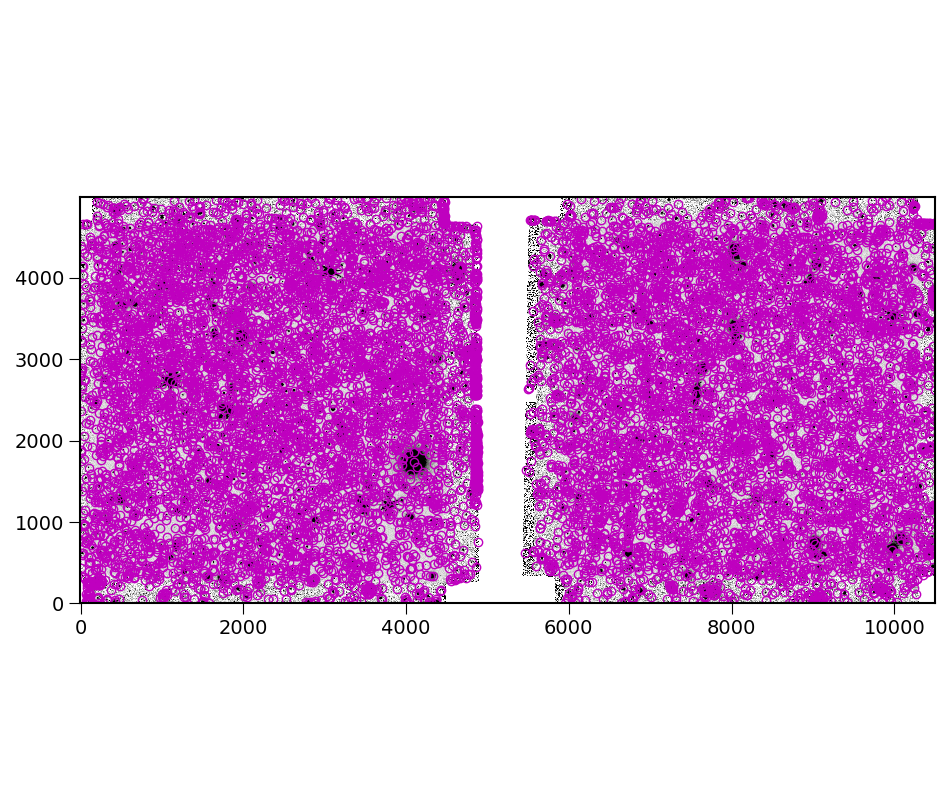

In [20]:
fig = plt.figure(figsize=(9.5, 8))
#norm = ImageNormalize(stretch=SqrtStretch(), vmin=0, vmax=0.5)
norm = ImageNormalize(vmin=-0.01, vmax=0.03)
plt.imshow(image_data, origin='lower', norm=norm, interpolation='none', cmap='Greys')
plt.plot(output_catalog['x'], output_catalog['y'], 'mo', mfc='None')

<IPython.core.display.Javascript object>


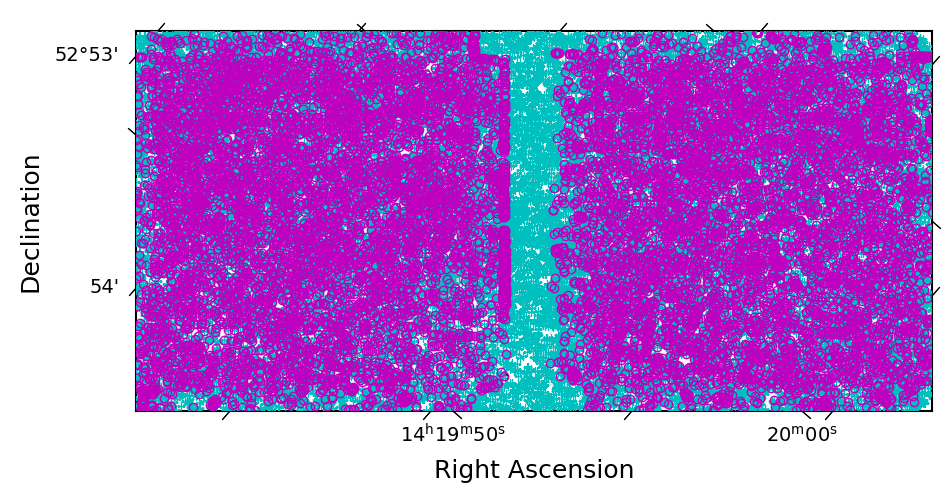

In [74]:
fig = plt.figure(figsize=(9.5, 5))
ax = fig.add_subplot(1, 1, 1, projection=imwcs) # , sharex=True, sharey=True)
norm = ImageNormalize(stretch=SqrtStretch(), vmin=0, vmax=0.5)
plt.imshow(image_data, origin='lower', norm=norm, interpolation='none', cmap='Greys')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.plot(input_catalog['ra'],  input_catalog['dec'],  'c+', mfc='None', transform=ax.get_transform('world'))
plt.plot(output_catalog['ra'], output_catalog['dec'], 'mo', mfc='None', transform=ax.get_transform('world'))

In [26]:
input_coordinates = SkyCoord(ra=input_catalog['ra']*u.deg, dec=input_catalog['dec']*u.deg)
input_catalog['x'], input_catalog['y'] = imwcs.world_to_pixel(input_coordinates)

<IPython.core.display.Javascript object>


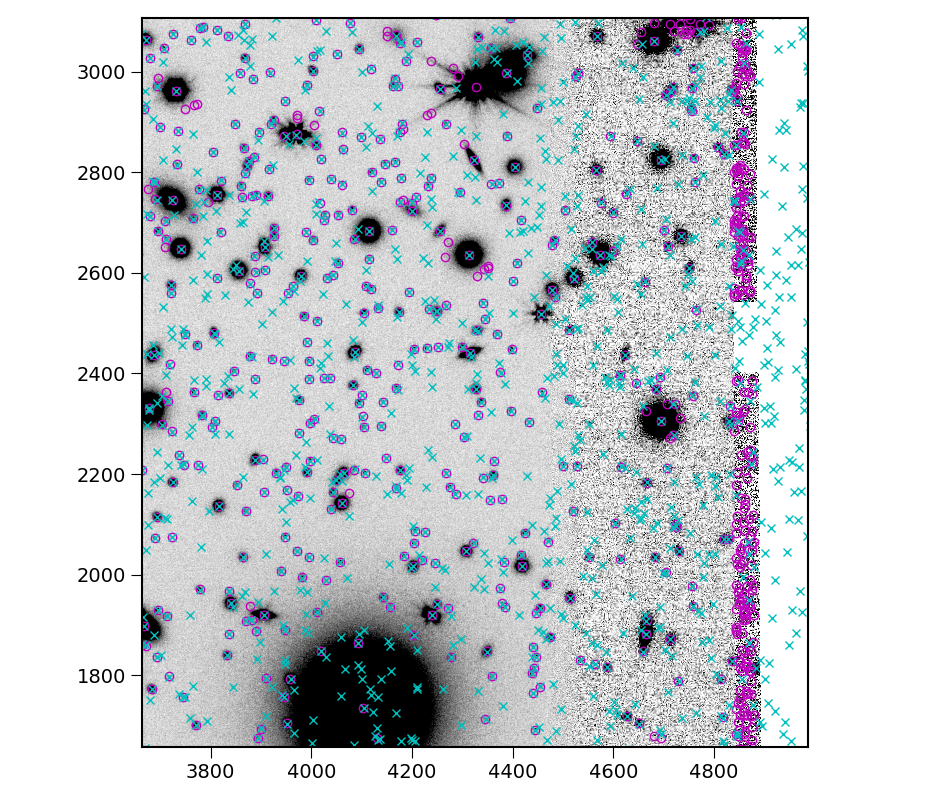

In [31]:
fig = plt.figure(figsize=(9.5, 8))
#norm = ImageNormalize(stretch=SqrtStretch(), vmin=0, vmax=0.5)
norm = ImageNormalize(vmin=-0.01, vmax=0.03)
plt.imshow(image_data, origin='lower', norm=norm, interpolation='none', cmap='Greys')
plt.plot(output_catalog['x'], output_catalog['y'], 'mo', mfc='None')
plt.plot(input_catalog['x'],  input_catalog['y'],  'cx', mfc='None')

# Match input objects to output photutils catalog

In [32]:
# Match input objects to output photutils catalog
# https://docs.astropy.org/en/stable/coordinates/matchsep.html
# Note ra, dec need to have units e.g., u.deg
input_coordinates = SkyCoord(ra=input_catalog['ra']*u.deg, dec=input_catalog['dec']*u.deg)
# Can use output_catalog['sky_centroid'] if saved in table, but this demo saved (ra,dec) instead:
detected_coordinates = SkyCoord(ra=output_catalog['ra']*u.deg, dec=output_catalog['dec']*u.deg)
input_match_indices, separation2d, distance3d = detected_coordinates.match_to_catalog_sky(input_coordinates)

<IPython.core.display.Javascript object>


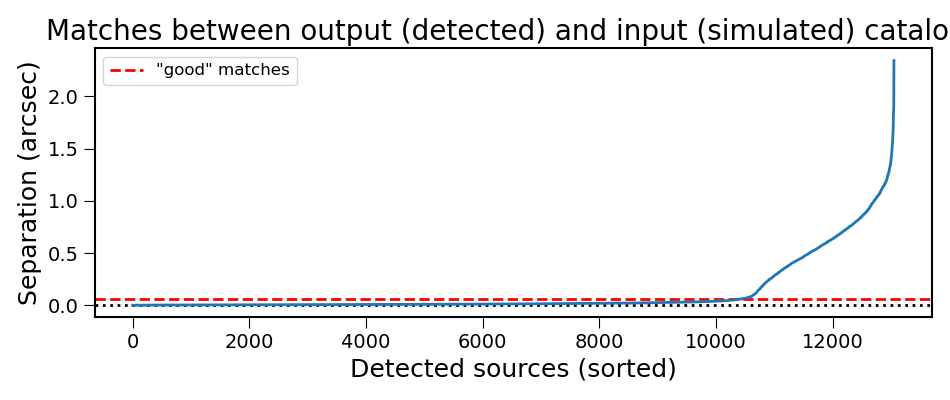

In [33]:
fig = plt.figure(figsize=(9.5, 4))
plt.rc('font', size=12)   
plt.plot(np.sort(separation2d.to(u.arcsec)), zorder=10)
separation_max = 0.06 * u.arcsec  # determined by eye after plotting
plt.axhline(0, c='k', ls=':')
plt.axhline(separation_max.value, c='r', ls='--', label='"good" matches')
plt.title('Matches between output (detected) and input (simulated) catalogs')
plt.xlabel('Detected sources (sorted)')
plt.ylabel('Separation (arcsec)')
plt.legend()

In [71]:
good_matches = separation2d < separation_max
unique_matches, index_counts = np.unique(input_match_indices[good_matches], return_counts=True)

#print('%d matches (%d unique) between input catalog (%d galaxies) and output photutils catalog (%d detected sources)'
#      % (np.sum(good_matches), len(unique_matches), len(input_catalog), len(output_catalog)))

print('%d matches between input catalog (%d galaxies) and output catalog (%d detected sources)'
      % (np.sum(good_matches), len(input_catalog), len(output_catalog)))

bright_enough = input_catalog['NIRCam_F200W'] < 30
print(np.sum(bright_enough), 'input sources bright enough for detection')

#print('%d%% of input sources were detected by photutils' % (100 * np.sum(good_matches) / len(input_catalog)))
# cheating a bit since a few fainter objects are also detected
print('%d%% of input sources (bright enough) were detected by photutils' % (100 * np.sum(good_matches) / np.sum(bright_enough)))
print('%d%% of output objects seem real (match input sources)' % (100 * np.sum(good_matches) / len(output_catalog)))

multiple_matches = unique_matches[index_counts > 1]
if len(multiple_matches):
    print('Input sources matched multiple times:', list(output_catalog['id'][multiple_matches]))

10422 matches between input catalog (27255 galaxies) and output catalog (13048 detected sources)
20190 input sources bright enough for detection
51% of input sources (bright enough) were detected by photutils
79% of output objects seem real (match input sources)


In [25]:
#input_catalog_matched  = input[input_match_indices][good_matches]
input_catalog_matched  = input_catalog[input_match_indices][good_matches]
output_catalog_matched = output_catalog[good_matches]

In [44]:
#input_catalog

<IPython.core.display.Javascript object>


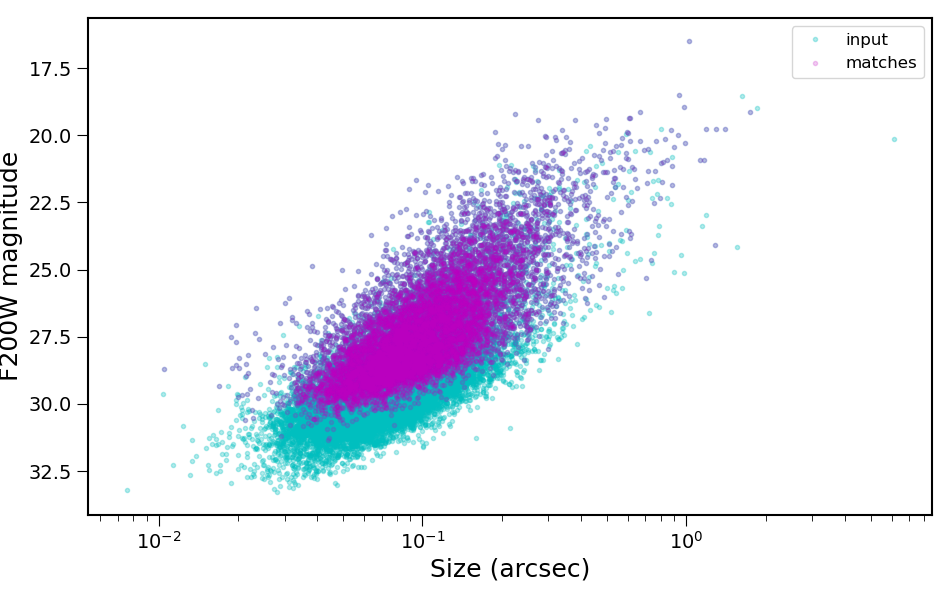

In [66]:
#angular_size NIRCam_F200W

fig = plt.figure(figsize=(9.5, 6))
plt.plot(input_catalog['angular_size'],         input_catalog['NIRCam_F200W'],         'c.', alpha=0.3, label='input')
plt.plot(input_catalog_matched['angular_size'], input_catalog_matched['NIRCam_F200W'], 'm.', alpha=0.2, label='matches')
#plt.title('Matches between output (detected) and input (simulated) catalogs')
plt.xlabel('Size (arcsec)')
plt.ylabel('F200W magnitude')
plt.ylim(plt.ylim()[::-1])
plt.semilogx()
plt.legend();

# Save matched catalogs

In [ ]:
# Save matched catalogs
input_catalog_matched.write(field+'_matched_SAM_input.ecsv', overwrite=True)
input_catalog_matched.write(field+'_matched_SAM_input.cat', format='ascii.fixed_width_two_line', delimiter=' ', overwrite=True)

output_catalog_matched.write(field+'_matched_phot-eazy.ecsv', overwrite=True)
output_catalog_matched.write(field+'_matched_phot-eazy.cat', format='ascii.fixed_width_two_line', delimiter=' ', overwrite=True)

In [ ]:
# Create a single merged catalog 
# starting with the input catalog
merged_catalog_matched  = input_catalog[input_match_indices][good_matches]  # just another copy
columns = 'haloid galid redshift mstar mcold Zstar Zcold mstardot sfr_ave meanage'
columns += ' acsf435w acsf606w acsf814w'
for filt in 'F090W F115W F150W F200W F277W F356W F410M F444W F480M'.split():
    columns += ' NIRCam_'+filt
columns = columns.split()
merged_catalog_matched = merged_catalog_matched[columns]

# and adding columns from the output catalog
columns = 'id area fwhm ellipticity gini kron_radius'
for filt in filters:
    columns += ' %s_flux' % filt
    columns += ' %s_fluxerr' % filt
columns += ' z_phot z_phot_chi2 z_phot_risk z_min_risk min_risk mass sfr Av'
columns = columns.split()
output_catalog_matched[columns]

for column in columns:
    merged_catalog_matched[column] = output_catalog_matched[column]
    
# Save matched catalogs
merged_catalog_matched.write(field+'_matched_SAM-input_phot-eazy.ecsv', overwrite=True)
merged_catalog_matched.write(field+'_matched_SAM-input_phot-eazy.cat', format='ascii.fixed_width_two_line', delimiter=' ', overwrite=True)